Todo:
- pořešit jednotu zápisů
- podíl největšího nakladatele / 3 největších apod.

In [2]:
import os
import re
import statistics
from src.najdi_rok import najdi_rok
import pandas as pd
from src.pocet_stran import pocet_stran
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [3]:
df = pd.read_parquet(os.path.join("data","cnb_vyber.parquet"))
df = df.explode('008')
df['rok'] = df['008'].apply(lambda x: najdi_rok(x))
df['stran'] = df['300_a'].apply(lambda x: pocet_stran(x))

In [4]:
df = df.dropna(subset=['245_a','100_a','rok'])

In [5]:
df = df.explode('260_b').explode('264_b')

In [6]:
def dvoje_nakladatelstvi(sedesat, sedesatctyri):
    if sedesat != None:
        return sedesat.replace(',','').replace(":",'').strip()
    elif sedesatctyri != None:
        return sedesatctyri.replace(',','').replace(":",'').strip()
    else:
        return None

In [7]:
df['nakladatel'] = df.apply(lambda row: dvoje_nakladatelstvi(row['260_b'], row['264_b']), axis=1)

In [8]:
df[(df['rok'] == 2021) & (df['nakladatel'].isnull())]

,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,rok,stran,nakladatel
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cpk20243582322,220106t20212021xr a f 010 0 cze d,[978-80-01-06880-9],None,[(brožováno)],"[cze, eng]",[cze],1,None,[72],[Architektura],"[159.953.34, 37.091.3, 378.6:62, 69.01/.03, 72...",[aut],jk01130435,"Šlapeta, Vladimír,",1947-,None,K jubileu výuky architektury na českém vysokém...,autor Vladimír Šlapeta ; editor Jiří Horský ; ...,None,None,"[Vladimír Šlapeta - recollections remarks, Vla...",[První vydání],None,None,None,None,None,None,None,"[V Praze :, None]",None,"[[2021], ©2021]","[1, 4]",[179 stran :],[ilustrace ;],[24 cm],None,None,None,None,[Souběžný anglický text],[1920-2020],"[studium a výuka, vysoké technické školy, stav...","[pe, None, st, au, None, dějiny, None, dějiny,...",None,None,[Česko],None,"[jubilejní publikace, eseje]","[edt, trl]","[mzk2007408165, ntka174143]","[Horský, Jiří, Tharp, Martin,]","[None, 1970-]",[pbl],[kn20010710176],[České vysoké učení technické v Praze.],[Fakulta architektury],None,None,None,cam a22 i 4500,2021.0,179.0,None
nkc20193147778,210527t20212021xr e 000 0 cze d,[978-80-270-6918-7],None,[(brožováno)],[cze],[eng],1,None,[615],[Farmacie. Farmakologie],"[615.214, 615.851:615.214, 615.074-027.236, 61...",[aut],xx0048407,"Metzner, Ralph,",1936-2019,Česky,Ropucha a jaguár :,Ralph Metzner ; s úvodem od Stanislava Grofa a...,None,None,None,[Vydání první],None,None,None,None,None,None,None,"[Ostrava :, None]",None,"[[2021], ©2021]","[1, 4]",[134 stran ;],None,[21 cm],None,None,[1000 výtisků],None,None,None,"[halucinogeny, psychedelická terapie, účinné l...",None,None,None,None,None,[populárně-naučné publikace],"[aft, aui, aft, trl]","[jn19990009830, xx0260797, jn20001227747, xx01...","[Grof, Stanislav,, Grob, Charles S.,, Vančura,...","[1931-, 1950-, 1948-, 1979-]",None,None,None,None,None,None,None,nam a22 i 4500,2021.0,134.0,None
nkc20193162890,191024t20212021xr a a 000 u cze d,[978-80-7292-380-9],None,[(vázáno)],[cze],[fre],1,None,[821-93-053.4],[Literatura pro nejmenší děti],"[821-93-053.4, 636.1/.9, (0.025.2), (086.7)]",[ill],xx0206378,"Billet, Marion,",1982-,Česky,Zvířátka na venkově :,ilustrovala Marion Billet ; z francouzského or...,None,None,None,None,None,None,None,None,None,None,None,"[Praha :, None]",None,"[[2021], ©2021]","[1, 4]",[16 nečíslovaných stran :],[barevné ilustrace ;],[15 cm],[Zvuková knížka],None,[Kartonové listy se zvukovými tlačítky a zvuko...,[Pro děti od 1 roku],None,None,"[domácí zvířata, domestic animals]",None,None,None,None,None,"[leporela, publikace pro nejmenší děti, knihy ...",[trl],[xx0042263],"[Kocmanová, Ivana,]",[1973-],None,None,None,None,[Zvuková knížka (Axióma)],None,None,cam a22 i 4500,2021.0,16.0,None
nkc20203174146,191104t20212021xr a a 000 j cze d,[978-80-7292-384-7],[349.00 Kč],[(vázáno) :],[cze],[fre],1,None,"[78.03, 0/9-053.2]","[Hudební styly, vlivy, školy, Literatura pro d...","[78.036.011.26, 780.61/.66, (0:82-32), (084.11...",[ill],xx0245721,"Le Huche, Magali,",1979-,Česky,Packa hraje rock /,ilustrovala Magali Le Huche ; z francouzského ...,None,None,None,None,None,None,None,None,None,None,None,"[Praha :, None]",None,"[[2021], ©2021]","[1, 4]",[30 nečíslovaných stran :],[barevné ilustrace ;],[21 cm],[Zvuková knížka],None,"[Obálkový podázev: 16 melodií k poslechu, List...",[Pro děti od 3 let],None,None,"[rock, hudební nástroje, rock music, musical i...",None,None,None,None,None,"[příběhy, obrazové publikace, knihy se zvuky, ...",[bkd],[xx0042263],"[Kocmanová, Ivana,]",[1973-],None,None,None,None,[Zvuková knížka (Axióma)],None,None,cam a22 i 4500,2021.0,30.0,None
nkc20203218126,200504t

In [9]:
df[df['nakladatel'].notnull()].groupby('rok').size() / df.groupby('rok').size()

rok
1900.0    1.000000
1901.0    1.000000
1902.0    0.999461
1903.0    0.999440
1904.0    1.000000
1905.0    0.999394
1906.0    0.999528
1907.0    0.999462
1908.0    1.000000
1909.0    1.000000
1910.0    0.999581
1911.0    0.999141
1912.0    1.000000
1913.0    0.999598
1914.0    0.998902
1915.0    1.000000
1916.0    1.000000
1917.0    1.000000
1918.0    0.998910
1919.0    0.999355
1920.0    1.000000
1921.0    1.000000
1922.0    0.999482
1923.0    0.999480
1924.0    0.999059
1925.0    0.999570
1926.0    1.000000
1927.0    0.999747
1928.0    0.998813
1929.0    0.999529
1930.0    0.998560
1931.0    0.999532
1932.0    0.998740
1933.0    0.999245
1934.0    0.999263
1935.0    0.999539
1936.0    0.999797
1937.0    0.999415
1938.0    0.999539
1939.0    0.998545
1940.0    0.998876
1941.0    1.000000
1942.0    0.999555
1943.0    1.000000
1944.0    1.000000
1945.0    0.999124
1946.0    0.999787
1947.0    1.000000
1948.0    0.999546
1949.0    1.000000
1950.0    1.000000
1951.0    1.000000
1952.0  

In [10]:
df['nakladatel'].sample(50)

001
bk193103493                                                 F. Slabý
nkc20122409375                                                  Jota
nkc20243606141                                     Krystal OP s.r.o.
nkc20102147956                                            Prometheus
cpk20061637192     Česká akademie císaře Františka Josefa pro věd...
nkc20112180437       Komitét pro udržování památek z války roku 1866
nkc20152727934                                    Sting spol. s r.o.
nkc20011172121                                     [Vítek Formánek?]
bk196301765                                                      SPN
nkc20091930788                                                J. Vaš
nkc20122429982                                                Leda ;
nkc20213351728                                            Powerprint
bk197304534                                                    Odeon
bk196404923                             Státní hudební vydavatelství
nos190247289                  

In [11]:
df[df['100_7'].astype(str).str.contains('jx20100301005',na=False)]

,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,rok,stran,nakladatel
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20182997195,180516s2018 xr g 000 j cze,[978-80-7549-850-2],None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-323.1)]",[aut],jx20100301005,"Kašpárek, Michal,",1984-,None,Hry bez hranic /,Michal Kašpárek,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Praha :],"Euromedia,",[2018],[1],[156 stran ;],None,[19 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české novely, satirické novely, Czech novella...",None,None,None,None,None,None,None,None,None,[Euromedia Group - Listen],None,nam a22 i 4500,2018.0,156.0,Euromedia
nkc20233549616,230925s2023 xr g 000 f cze,[978-80-7637-400-3],None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jx20100301005,"Kašpárek, Michal,",1984-,None,Fosilie /,Michal Kašpárek,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Praze :],"Paseka,",[2023],[1],[183 stran ;],None,[20 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,2023.0,183.0,Paseka


In [12]:
df[df['nakladatel'] == 'Listen'].sort_values(by='rok')

,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,rok,stran,nakladatel
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cpk19970277303,980429s1997 xr c e 000 mdcze,[80-902360-0-6],None,[(brož.)],None,None,None,None,[394],[Veřejný a společenský život. Každodenní život],[392/396],[aut],jn19990218034,"Jirků, Irena,",1963-,None,Tvář na dluh /,"[texty Irena Jirků, Marcela Kašpárková, Boris ...",None,None,None,[1. vyd.],None,[Jihlava :],"Listen,",[1997],None,None,None,None,None,None,None,[173 s. :],[portréty ;],[21 cm],None,None,None,None,None,[1940-1997],[každodenní život],None,[1940-1997],[Česko],None,None,[literatura faktu],"[aut, aut, com]","[jn19990218042, jn19990218017, ntka174193]","[Kašpárková, Marcela,, Dočekal, Boris,, Turek,...","[1962-, 1950-, 1939-]",None,None,None,None,None,None,None,nam a22 a 4500,1997.0,173.0,Listen
cpk19980318422,980518s1998 xr c e 000 m cze,[80-902360-1-4],None,[(váz.)],None,None,None,None,[316.4/.7],[Sociální interakce. Sociální komunikace],"[316.346.2, 177.6, 316.346.2-055.2, 7.04, (047...",[aut],jn19990218017,"Dočekal, Boris,",1950-,None,"Pane, to je krása :",Boris Dočekal,None,None,None,[1. vyd.],None,[Jihlava :],"Listen,",[1998],None,None,None,None,None,None,None,[111 s. :],[portréty (některé barev.) ;],[22 cm],None,None,None,None,None,None,"[muži a ženy, partnerské vztahy, ženy, uměleck...",None,None,None,None,None,"[fotografické publikace, rozhovory, photograph...",[aut],[jn19990209462],"[Labuda, Marián,]",[1944-2018],None,None,None,None,None,None,None,nam a22 a 4500,1998.0,111.0,Listen
cpk19990738645,990927s1999 xr acf e 000 macze,[80-902360-2-2],None,[(váz.)],None,None,None,None,"[7.01/.09, 929]","[Umění, Biografie]","[75.071.1, 929, 7.071, 001.83-027.22, (0:82-94)]","[aut, art]",jn19990009901,"Kundera, Rudolf,",1911-2005,None,Rendez-vous s Rudolfem Kunderou :,Irena Jirků,None,None,None,[1. vyd.],None,[Jihlava :],"Listen,",[1999],None,None,None,None,None,None,None,"[117 s., [32] s. obr. příl. (některé barev.) :]","[il., portréty ;]",[22 cm],None,None,"[Životopisná data R. Kundery, Poznámka o význa...",None,None,[20. století],"[malíři, umělci, intelektuální život, painters...",None,"[20. století, 20. století, 20. století, 20th c...","[Česko, None, None, Czechia, None, None]",None,None,"[autobiografické vzpomínky, vzpomínky, autobio...",[aut],[jn19990218034],"[Jirků, Irena,]",[1963-],None,None,None,None,None,None,None,nam a22 a 4500,1999.0,117.0,Listen
cpk20000703085,000505s2000 xr af e 000 macze,[80-902360-3-0],None,[(váz.)],None,None,None,None,[929],[Biografie],"[929, 791/792.071.2, (047.53), (0:82-94)]",[aut],jn19990009653,"Lasica, Milan,",1940-2021,None,Melancholický klaun Milan Lasica :,Boris Dočekal,None,None,None,[1. vyd.],None,[Jihlava :],"Listen,",[2000],None,None,None,None,None,None,None,"[127 s., [8] s. obr. příl. :]",[il. ;],[21 cm],None,None,None,None,None,None,"[herci, Actors and actresses]","[None, Interviews]",None,"[Slovensko, Slovakia]",None,None,"[vzpomínky, rozhovory]",[ivr],[jn19990218017],"[Dočekal, Boris,]",[1950-],None,None,None,None,None,None,None,cam a22 a 4500,2000.0,127.0,Listen
cpk20000980115,010201s2000 xr ac e 000 mdcze,[80-902360-4-9],None,[(váz.)],None,None,None,None,[929],[Biografie],"[929, (437.3), (0:82-94), (082)]",[com],jn19990218017,"Dočekal, Boris,",1950-,None,"Maminka, tatínek a já :",Boris Dočekal,None,None,None,[1. vyd.],None,[Jihlava :],"Listen,",[2000],None,None,None,None,None,None,None,[133 s. :],"[il., portréty ;]",[22 cm],None,None,None,None,None,None,"[osobnosti, osobnosti, celebrities, celebrities]","[None, dětství, None, childhood]",None,"[Česko, None, Czechia, None]",None,None,"[sborníky, vzpomínky, mis

In [13]:
df[df['nakladatel'] == 'Paseka'].sort_values(by='rok')

,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,rok,stran,nakladatel
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ck9104408,911009s1990 xr a e 000 f cze,[80-85192-01-2],None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jk01060531,"Klíma, Ladislav,",1878-1928,None,Utrpení knížete Sternenhocha :,Ladislav Klíma ; ilustrace Karel Nepraš,None,None,None,[Vydání 3.],None,None,None,None,None,None,None,[Praha :],"Paseka,",[1990],[1],[203 stran :],[ilustrace ;],[21 cm],None,None,[45000 výtisků],None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",[ill],[jk01083190],"[Nepraš, Karel,]",[1932-2002],None,None,None,None,None,None,"[Klíma, Ladislav (spisovatel a filozof čes., 1...",nam a22 i 4500,1990.0,203.0,Paseka
np9433293,950103s1990 xr a g 000 f cze,[80-85192-00-4],"[Kčs 37,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, 82-91, 087.6, (437.3), (0:82-31...","[aut, ill]",jk01141125,"Váchal, Josef,",1884-1969,None,Krvavý román /,Josef Váchal,None,None,None,[Vydání třetí],None,None,None,None,None,None,None,[Praha :],"Paseka,",[1990],[1],[318 stran :],[ilustrace ;],[21 cm],[Knihy Josefa Váchala ;],[svazek I.],[40000 výtisků],None,None,None,"[populární literatura, kolportážní literatura,...",None,None,"[Česko, Česko, Czechia, Czechia]",None,None,"[české romány, parodie, autorské knihy, studie...",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,1990.0,318.0,Paseka
cpk20000533892,910220s1990 xr ac e 001 0 cze,[80-85192-03-9],"[Kčs 39,00]",[(váz.) :],None,None,None,None,[641],[Kuchařství. Potraviny. Vařená jídla],"[641.55, (083.12)]",[aut],jk01060037,"Kejřová, Anuše,",1874-1926,None,Úsporná kuchařka :,z vlastních zkušeností napsala a sestavila Anu...,None,None,[Zlatá kniha malé domácnosti],None,None,[Praha :],"Paseka,",[1990],None,None,None,None,None,None,None,[330 s. :],"[il., portréty ;]",[21 cm],None,None,"[95000 výt., Obsahuje rejstřík]",None,None,None,[jídla],None,None,None,None,None,[kuchařské recepty],None,None,None,None,None,None,None,None,None,None,None,nam a22 a 4500,1990.0,330.0,Paseka
nkc20070535080,920805s1990 xr a g 000 f cze,[80-85192-05-5],"[Kčs 24,00]",[(váz.) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-3, (0:82-3)]",[aut],xx0012051,"Cír, Jaroslav,",1966-,None,Zahrada s kocourem /,Jaroslav Cír ; [ilustrovala Lenka Stará],None,None,None,[Vyd. 1.],None,[Praha :],"Paseka,",[1990],None,None,None,None,None,None,None,[101 s. :],[il. ;],[18 cm],None,None,[5000 výt.],None,None,None,None,None,None,None,None,None,[české prózy],None,None,None,None,None,None,None,None,None,None,None,nam a22 a 4500,1990.0,101.0,Paseka
ck9201658,920410s1991 xr a u0|0 cze,[80-85192-10-1],None,[(váz.)],None,None,None,None,None,None,[718(=924)(437.1/.2)(084.1)],[pht],None,"Ehl, Petr",None,None,Staré židovské hřbitovy Čech a Moravy :,"[fotogr.] Petr Ehl ; [text] Arno Pařík, Jiří F...",None,None,None,[Vyd. 1.],None,[Praha :],"Paseka,",[1991],None,[(Svoboda)],None,None,None,None,None,[173 s. :],[il. ;],[28 cm],None,None,"[Frontispis, Zdobené předsádky, 4000 výt.]",None,None,None,None,None,None,None,None,None,[fotografické publikace],"[aut, aut]","[jo20000074497, jk01031083]","[Pařík, Arno,, Fiedler, Jiří,]","[1948-, 1935-2014]",None,None,None,None,None,None,[Čechy - Morava - hřbitovy židovské - publikac...,nam a22 4500,1991.0,173.0,Paseka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## Nejproduktivnější nakladatelství

In [15]:
df.groupby('nakladatel').size().nlargest(60)

nakladatel
SPN                                  22390
SNTL                                 13328
MOBA                                  9329
Mladá fronta                          8035
Albatros                              7960
Československý spisovatel             6188
Grada                                 6018
Orbis                                 5698
Práce                                 5610
Naše vojsko                           5339
Knižní klub                           5032
ČVUT                                  4786
Dilia                                 4682
Ikar                                  4588
Ivo Železný                           4452
Fragment                              4320
nákladem vlastním                     4288
Odeon                                 4132
Státní pedagogické nakladatelství     4109
Academia                              4003
Svoboda                               3976
Argo                                  3629
Portál                                3382


In [16]:
df[df['rok'] > 2013].groupby('nakladatel').size().nlargest(60)

nakladatel
MOBA                                           3809
Euromedia Group                                2691
Dobrovský s.r.o.                               2531
Fragment                                       2083
Albatros                                       1960
Argo                                           1958
CPress                                         1947
Ikar                                           1688
Host                                           1363
Mladá fronta                                   1351
Grada                                          1250
Svojtka & Co.                                  1243
Portál                                         1212
Knižní klub                                    1157
Grada Publishing                               1056
Nová Forma                                     1016
Univerzita Palackého v Olomouci                 924
Wolters Kluwer                                  921
Academia                                        886
B

## Počet jednotlivých nakladatelství

<Axes: xlabel='rok'>

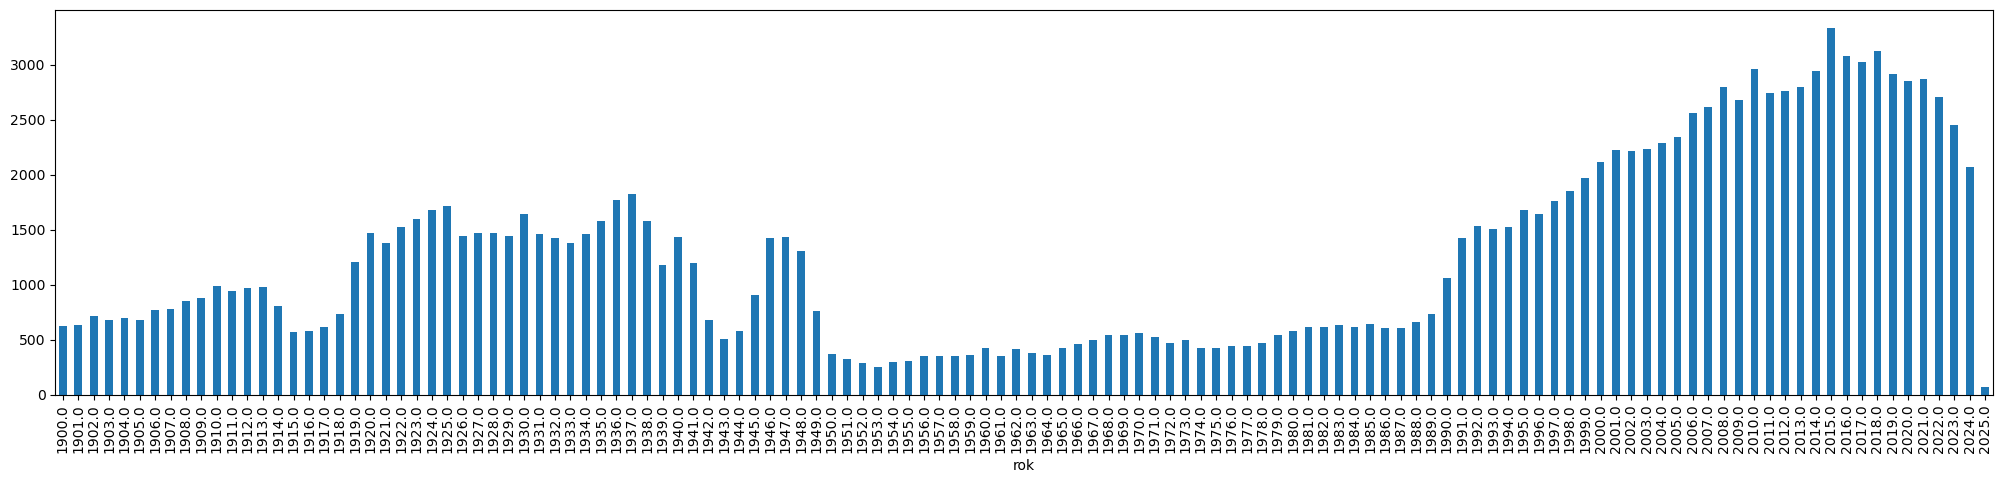

In [18]:
df.groupby('rok')['nakladatel'].nunique().plot.bar(figsize=(25,5))

In [19]:
df.groupby('rok')['nakladatel'].nunique().nlargest()

rok
2015.0    3330
2018.0    3124
2016.0    3074
2017.0    3027
2010.0    2963
Name: nakladatel, dtype: int64

In [20]:
df[df['rok'] == 1953].groupby('nakladatel').size().nlargest(15)

nakladatel
SPN                                           605
SNTL                                          334
Orbis                                         314
Práce                                         199
Československý spisovatel                     173
Naše vojsko                                   149
SZN                                           139
Státní pedagogické nakladatelství             128
Nakladatelství Československé akademie věd    126
SNDK                                          125
SNKLHU                                        122
ČDLJ                                          120
SZdN                                           97
Mladá fronta                                   87
SNPL                                           82
dtype: int64

## Počet nových nakladatelství

<Axes: xlabel='rok'>

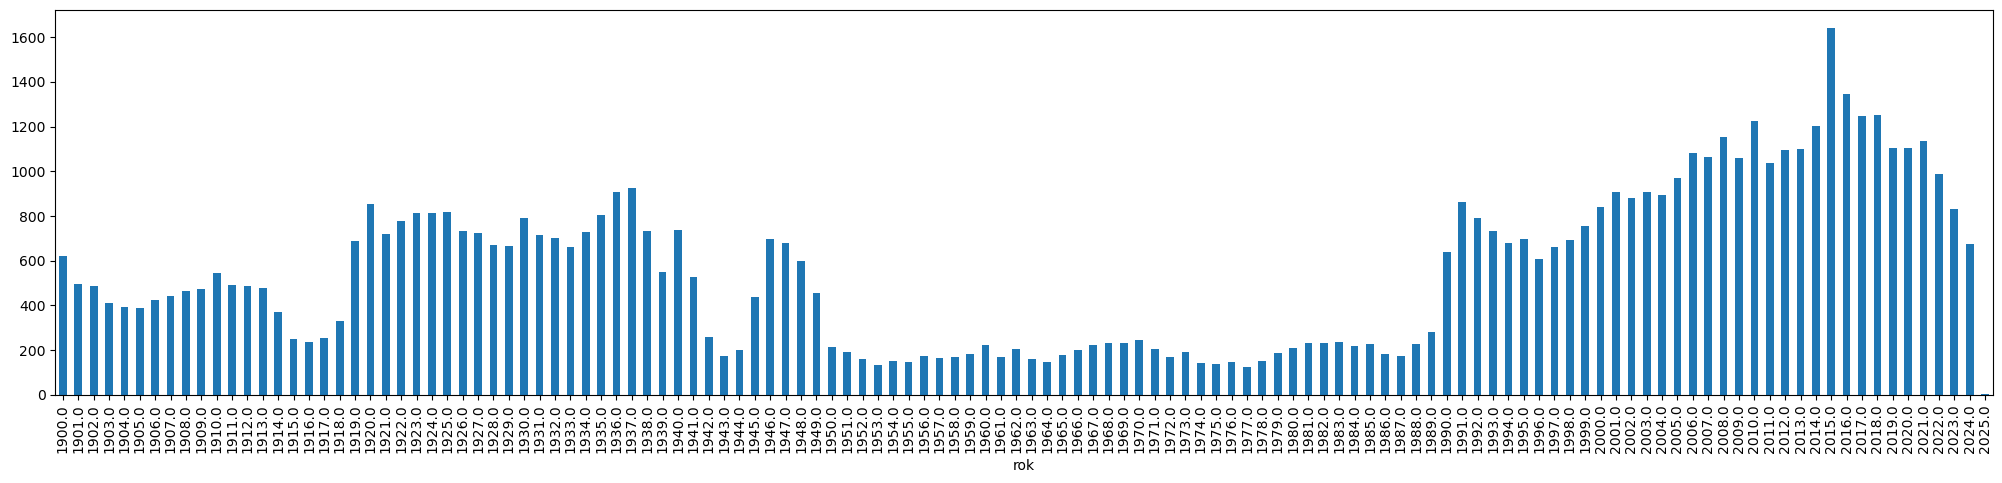

In [22]:
pd.DataFrame(df.groupby('nakladatel')['rok'].min()).groupby('rok').size().plot.bar(figsize=(25,5))

## Počet končících nakladatelství

<Axes: xlabel='rok'>

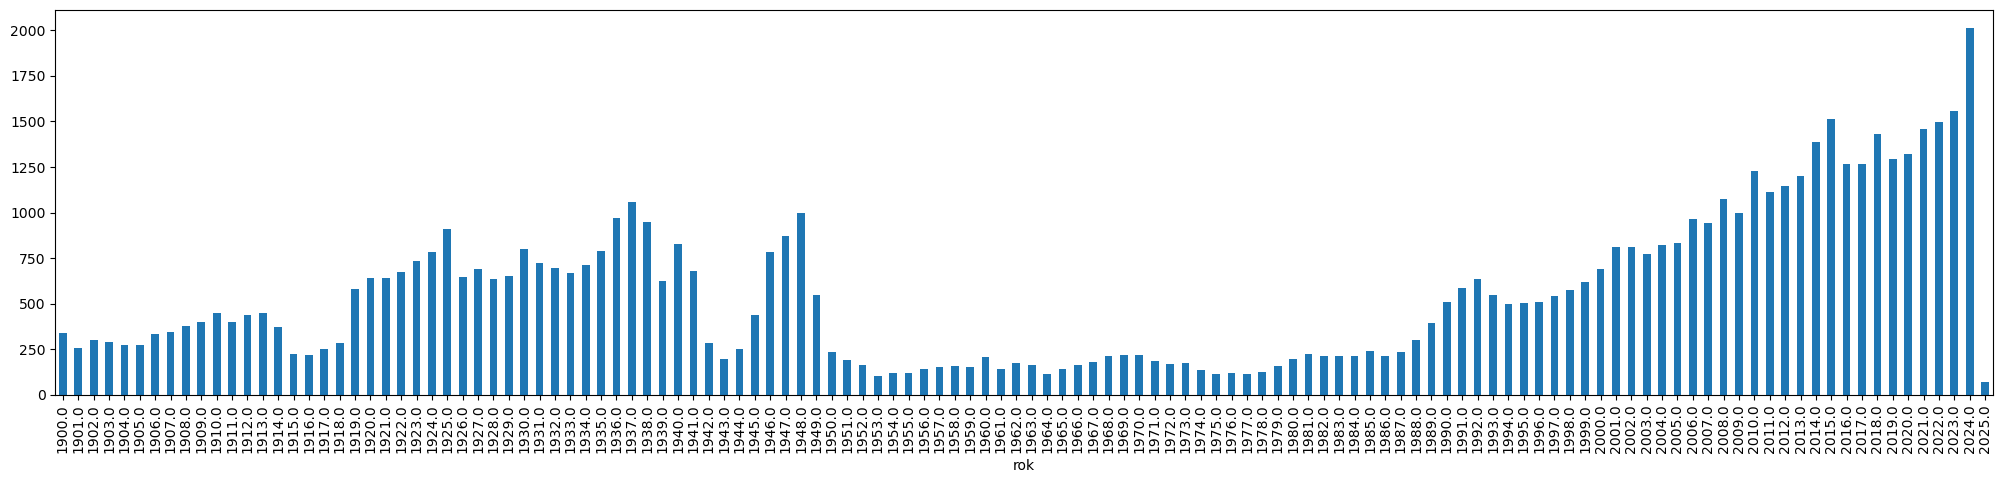

In [24]:
pd.DataFrame(df.groupby('nakladatel')['rok'].max()).groupby('rok').size().plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

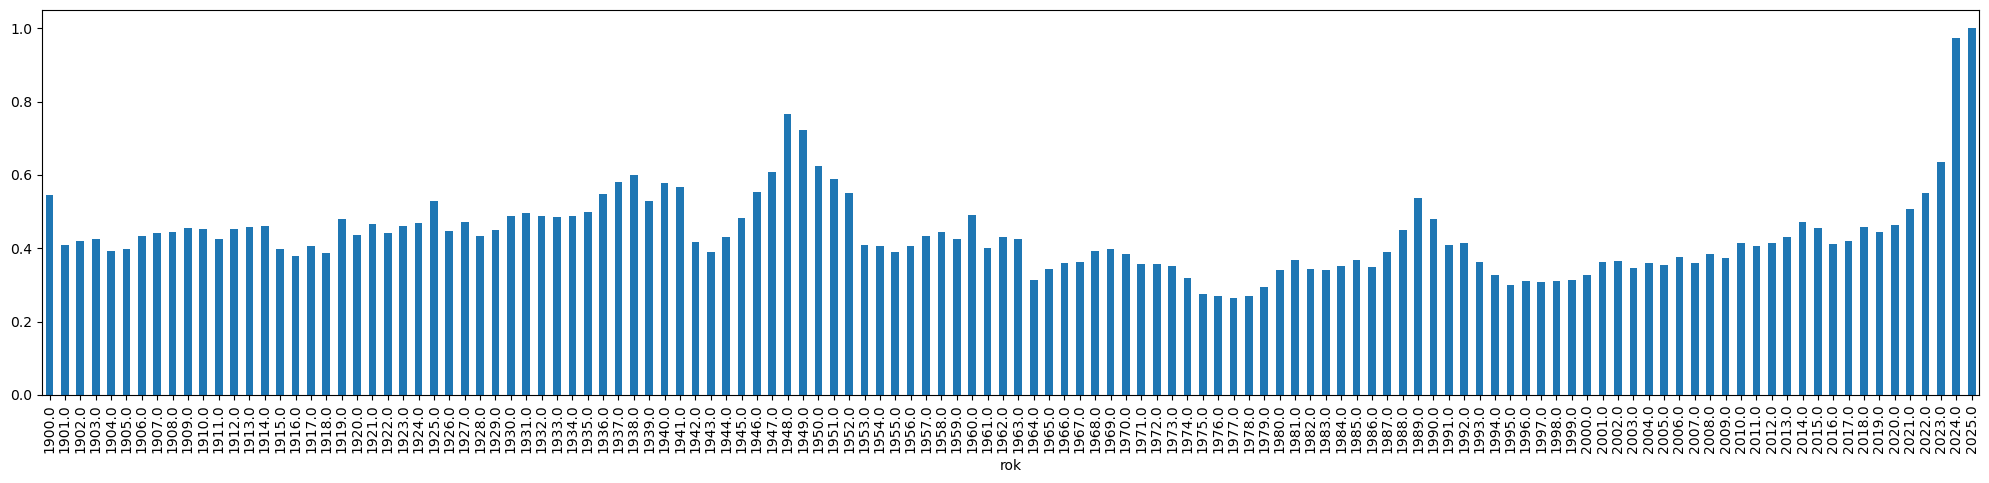

In [25]:
(pd.DataFrame(df.groupby('nakladatel')['rok'].max()).groupby('rok').size() / df.groupby('rok')['nakladatel'].nunique()).plot.bar(figsize=(25,5))

In [26]:
(pd.DataFrame(df.groupby('nakladatel')['rok'].max()).groupby('rok').size() / df.groupby('rok')['nakladatel'].nunique()).nlargest(10)

rok
2025.0    1.000000
2024.0    0.972437
1948.0    0.766692
1949.0    0.723684
2023.0    0.636178
1950.0    0.625000
1947.0    0.608787
1938.0    0.600126
1951.0    0.589666
1937.0    0.580504
dtype: float64

In [27]:
pd.DataFrame(df[df['rok'] < 1990].groupby('nakladatel')['rok'].max()).groupby('rok').size().nlargest(5)

rok
1937.0    1078
1948.0    1028
1936.0     979
1938.0     967
1925.0     915
dtype: int64

In [28]:
pd.DataFrame(df.groupby('nakladatel')['rok'].max()).groupby('rok').size()

rok
1900.0     340
1901.0     260
1902.0     303
1903.0     288
1904.0     274
1905.0     272
1906.0     336
1907.0     345
1908.0     378
1909.0     402
1910.0     451
1911.0     401
1912.0     441
1913.0     450
1914.0     375
1915.0     227
1916.0     219
1917.0     250
1918.0     284
1919.0     580
1920.0     642
1921.0     641
1922.0     673
1923.0     737
1924.0     786
1925.0     908
1926.0     649
1927.0     693
1928.0     636
1929.0     650
1930.0     803
1931.0     725
1932.0     699
1933.0     671
1934.0     714
1935.0     788
1936.0     970
1937.0    1060
1938.0     950
1939.0     624
1940.0     830
1941.0     680
1942.0     283
1943.0     198
1944.0     251
1945.0     439
1946.0     786
1947.0     873
1948.0     999
1949.0     550
1950.0     235
1951.0     194
1952.0     162
1953.0     104
1954.0     122
1955.0     122
1956.0     144
1957.0     154
1958.0     157
1959.0     156
1960.0     208
1961.0     142
1962.0     178
1963.0     162
1964.0     113
1965.0     145
1966.0

## Grafy

In [30]:
import altair as alt

In [31]:
def irozhlas_conf():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 14,
                      'anchor': 'start',
                       'fontWeight': 'bolder',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 12,
                       'subtitleFontWeight': 'lighter',
                      'subtitlePadding': 12,
                       'dy': -12,
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                 "fontWeight": "lighter",
                "titleFontWeight": "lighter",
                "labelFontSize": 10,
                "titleFontSize": 10,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 10,
                "titleFontSize": 10
            }
        }
    }

alt.themes.register('irozhlas', irozhlas_conf)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')

In [32]:
nakladatelstvi_s_tremi_knihami = df.groupby("nakladatel").size()
nakladatelstvi_s_tremi_knihami = nakladatelstvi_s_tremi_knihami[nakladatelstvi_s_tremi_knihami >= 3].index.to_list()
df_aspon_tri = df[df['nakladatel'].isin(nakladatelstvi_s_tremi_knihami)]

In [33]:
jednotliva = pd.DataFrame(df_aspon_tri.groupby('rok')['nakladatel'].nunique()).reset_index().rename(columns={"nakladatel": "celkem"})
nova = pd.DataFrame(df_aspon_tri.groupby('nakladatel')['rok'].min()).groupby('rok').size().reset_index().rename(columns={0: "nová"})
koncici = pd.DataFrame(df_aspon_tri.groupby('nakladatel')['rok'].max()).groupby('rok').size().reset_index().rename(columns={0: "končící"})
do_grafu = jednotliva.merge(nova, on="rok", how="left")
do_grafu = do_grafu.merge(koncici, on="rok", how="left")
do_grafu = do_grafu.melt(id_vars="rok")
do_grafu = do_grafu[do_grafu['rok'] >= 1920]
do_grafu = do_grafu[do_grafu['rok'] <= 2020]
do_grafu['rok'] = pd.to_datetime(do_grafu['rok'].apply(lambda x: f"{int(x)}-01-01"))
do_grafu

,rok,variable,value
20,1920-01-01,celkem,815.0
21,1921-01-01,celkem,756.0
22,1922-01-01,celkem,863.0
23,1923-01-01,celkem,908.0
24,1924-01-01,celkem,962.0
25,1925-01-01,celkem,965.0
26,1926-01-01,celkem,811.0
27,1927-01-01,celkem,831.0
28,1928-01-01,celkem,878.0
29,1929-01-01,celkem,835.0


In [34]:
alt.Chart(do_grafu).mark_line().encode(
    x='rok:T',
    y='value:Q',
    color='variable:N',
)

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [35]:
from textwrap import wrap

In [36]:
titulek='Kolik různých nakladatelství vydávalo knihy'
podtitulek="Nejhůř poznamenaly pestrost nakladatelské scény nacistická okupace a komunistický režim. Do grafu se promítají pouze nakladatelství tří a více knih."
podtitulek=wrap(podtitulek, 60)

In [37]:
graf_nakl = alt.Chart(do_grafu, title={'text': titulek}, width=300).mark_area().encode(
    alt.X("rok:T", 
          title=None,
          axis=alt.Axis(domainOpacity=0, tickColor='#DCDDD6')
    ),
    alt.Y('value:Q', 
          axis=alt.Axis(domainOpacity=0, tickColor='#DCDDD6', orient='right', format='~s'), 
          title=None
    ),
    alt.Color("variable:N", 
              scale=alt.Scale(range=['#D55F50', '#ECD410', '#9CA545']), ##['#DB842F', '#81A9D5', '#E09DA3']), ## '# ['#a7ddd6','#001f80','#e6e6e4','#e5db00','#e49996','#9cc002']), 
              title=None, 
              legend=None
    ),
    row=alt.Row(
        "variable:N", 
        title=None, 
        spacing=15, 
        header=alt.Header(labelAngle=0, labelAlign='left', labelAnchor='middle', labelFont='Asap'),
                sort=['celkem', 'nová', 'končící'],

    )
).resolve_axis(
    x='independent'
).resolve_scale(
    y='independent'
).properties(height=100, width=300).configure_view(stroke='transparent').configure_view(stroke='transparent')

graf_nakl

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [38]:
subtitle=""

In [39]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):

    os.makedirs("grafy", exist_ok=True)
    
    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas(), width=300).encode(text=alt.Text('text:N')).mark_text(fontSize=10,font="Asap", baseline='line-bottom')
    combined_chart = alt.vconcat(zaklad_grafu, credits)

    combined_chart.save(os.path.join("grafy",f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy",f"{soubor}.png"), ppi=400)

    print(f"""<a href="https://michalkasparek.cz/sklad/podily_jazyku.svg" target="_blank"><img src="https://michalkasparek.cz/sklad/{soubor}.svg" alt="{subtitle}" width="100%" style="background-color: white; padding: 0.2em 0 0.6em 0"></img></a>""")
    
    return combined_chart

In [40]:
import polars as pl

### Podíl největšího

In [42]:
nakl = df.groupby(["nakladatel","rok"]).size().reset_index().rename(columns={0: 'knih'})
knih_za_rok = nakl.groupby("rok")["knih"].sum().reset_index().rename(columns={'knih': 'celkem'})
nakl = nakl.merge(knih_za_rok, on="rok", how="left")
nakl['podíl'] = nakl['knih'] / nakl['celkem']
nakl

,nakladatel,rok,knih,celkem,podíl
0,"""Ars"" Doležal & Steinbrener",1944.0,2,2187,0.000914
1,"""Cíl""",1948.0,1,4407,0.000227
2,"""Diasan"" - dietní stanice pro diabetiky",1938.0,1,4334,0.000231
3,"""Dillia"" Čs. divadelní a literární jednatelství",1958.0,1,3941,0.000254
4,"""Domov""",1942.0,1,2244,0.000446
...,...,...,...,...,...
158048,Žďárský,1919.0,1,3098,0.000323
158049,Žďárský,1920.0,1,3938,0.000254
158050,Žďárský,1946.0,1,4701,0.000213
158051,Žďárský obzor,1909.0,1,2109,0.000474


In [44]:
str(nakl.sample(8))

'                                               nakladatel     rok  knih  \\\n92055                                 Prof. dr. K. Slavík  1907.0     1   \n128560             Výzkumný ústav výstavby a architektury  1969.0     1   \n22281                                    Emanuel Všetečka  1939.0     1   \n102973                                     Sokolské nakl.  1951.0     9   \n127218                                      Výkonný výbor  1920.0     1   \n94302                                             R. Rupp  1920.0     1   \n140432  nákladem a tiskem Jednoty československých mat...  1927.0     1   \n138240                                       nákl. vlast.  1928.0    12   \n\n        celkem     podíl  \n92055     1859  0.000538  \n128560    3857  0.000259  \n22281     3432  0.000291  \n102973    3381  0.002662  \n127218    3938  0.000254  \n94302     3938  0.000254  \n140432    3954  0.000253  \n138240    4207  0.002852  '

In [46]:
nakl.sort_values(by='podíl', ascending=False)

,nakladatel,rok,knih,celkem,podíl
98536,SPN,1960.0,782,4321,0.180977
84212,Orbis,1943.0,332,1850,0.179459
98541,SPN,1965.0,684,3821,0.179011
98537,SPN,1961.0,727,4349,0.167165
98538,SPN,1962.0,687,4140,0.165942
...,...,...,...,...,...
79927,Obec Potštejn,2008.0,1,13499,0.000074
9747,Babyonline,2008.0,1,13499,0.000074
154271,České muzeum stříbra],2008.0,1,13499,0.000074
77486,Národní knihovna ČR - Slovanská knihovna,2008.0,1,13499,0.000074


In [48]:
samonaklad = ['nákladem vlastním','nákl. vlast.','nákl. vl.']

In [50]:
result = nakl[~nakl['nakladatel'].isin(samonaklad)].sort_values(['rok', 'podíl'], ascending=[True, False]).drop_duplicates('rok')
print(result)
result = result[result['rok'].isin(range(1920,2023))]
result['rok'] = pd.to_datetime(result['rok'].apply(lambda x: f"{int(x)}-01-01"))
result = result.replace({'IŽ': 'Železný','Ivo Železný':'Železný','Euromedia Group':'Euromedia'})
nejcastejsi = result.groupby('nakladatel').size() 
print(nejcastejsi.nlargest(15))
nejcastejsi = nejcastejsi[nejcastejsi >=4 ].index.to_list()
print(nejcastejsi)
nenahrazeni = {x : x for x in nejcastejsi}
print(nenahrazeni)
result = pl.from_pandas(result).with_columns(pl.col('nakladatel').replace_strict(nenahrazeni, default='ostatní')).to_pandas()
result

                                               nakladatel     rok  knih  \
76734   Nákladem České akademie císaře Františka Josef...  1900.0    40   
38083                                             J. Otto  1901.0    63   
38084                                             J. Otto  1902.0    90   
38085                                             J. Otto  1903.0    84   
38086                                             J. Otto  1904.0    61   
38087                                             J. Otto  1905.0    63   
94321                                           R. Storch  1906.0   193   
9054                                              B. Kočí  1907.0    90   
38090                                             J. Otto  1908.0    80   
76743   Nákladem České akademie císaře Františka Josef...  1909.0    51   
38092                                             J. Otto  1910.0    96   
38093                                             J. Otto  1911.0    82   
38094                    

,nakladatel,rok,knih,celkem,podíl
0,ostatní,1920-01-01,92,3938,0.023362
1,ostatní,1921-01-01,93,3465,0.026840
2,ostatní,1922-01-01,75,3856,0.019450
3,ostatní,1923-01-01,72,3847,0.018716
4,ostatní,1924-01-01,104,4245,0.024499
5,ostatní,1925-01-01,112,4646,0.024107
6,ostatní,1926-01-01,140,4150,0.033735
7,ostatní,1927-01-01,123,3954,0.031108
8,ostatní,1928-01-01,103,4207,0.024483
9,ostatní,1929-01-01,103,4240,0.024292


In [52]:
result['nakladatel'].nunique()

6

In [54]:
razeni = result['nakladatel'].drop_duplicates().to_list()

In [56]:
titulek2 = "Podíl největšího nakladatelství na vydaných knihách"
podtitulek2 = wrap("Za první republiky vydávali nejvíce knih střídavě J. Otto, B. Kočí, Jos. R. Vilímek a Fr. Švejda, často se také na první příčce objevoval samonáklad. Monopol Státního pedagogického nakladatelství za socialismu krátkodobě narušovalo Státní nakladatelství technické knihy. Po revoluci se krátkodobě prosadila nakladatelství Harlequin, BB art, Grada a univerzitní nakladatelství ČVUT a UPOL.",70)

In [60]:
graf_nejvesi = alt.Chart(result, title={'text': titulek2}, width=330).mark_area(width=3).encode(
    alt.X("rok:T", 
          title=None,
          axis=alt.Axis(domainOpacity=0, tickColor='#DCDDD6')
    ),
    alt.Y('podíl:Q', 
          axis=alt.Axis(domainOpacity=0, tickColor='#DCDDD6', orient='right', labelExpr="datum.label * 100 + ' %'"), 
          title=None
    ),
    alt.Color("nakladatel:N", 
              scale=alt.Scale(range=['#F2E9DE', '#DFBD6E', '#588438', '#33444C', '#C8414D', '#6B8EAA']), ## '# ['#a7ddd6','#001f80','#e6e6e4','#e5db00','#e49996','#9cc002']), 
              title=None,
               sort=razeni,
              legend=alt.Legend(orient="top")
    )).configure_view(stroke='transparent')

graf_nejvesi

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [ ]:
graf_nejvesi.save("grafy/pokus1.svg")

In [ ]:
credits = pl.DataFrame({'text': ['zdroj dat: Česká národní bibliografie · vizualizace: iROZHLAS.cz · 2025']})
credits = alt.Chart(credits.to_pandas(), width=300, height=30).encode(text=alt.Text('text:N')).mark_text(fontSize=10, font="Asap", baseline='line-bottom')
credits.save("grafy/pokus2.svg")

In [ ]:
import svgutils.transform as sg
import xml.etree.ElementTree as ET

In [ ]:
## TOTO KONEČNĚ FUNGUJE

from lxml import etree

def concatenate_svg_vertically(image1_path, image2_path, output_path):
    # Load both SVG files as XML
    with open(image1_path, 'r', encoding='utf-8') as f:
        svg1 = etree.parse(f)

    with open(image2_path, 'r', encoding='utf-8') as f:
        svg2 = etree.parse(f)

    # Extract root elements
    root1 = svg1.getroot()
    root2 = svg2.getroot()

    # Get width & height of both SVGs
    width1 = int(root1.get("width", "0").replace("px", ""))
    height1 = int(root1.get("height", "0").replace("px", ""))
    width2 = int(root2.get("width", "0").replace("px", ""))
    height2 = int(root2.get("height", "0").replace("px", ""))

    # Set new dimensions
    new_width = max(width1, width2)
    new_height = height1 + height2

    # Create a new SVG root element
    new_svg = etree.Element("svg", xmlns="http://www.w3.org/2000/svg",
                            width=f"{new_width}px", height=f"{new_height}px")

    # Append a white background rectangle
    background = etree.Element("rect", width=str(new_width), height=str(new_height), fill="white")
    new_svg.append(background)

    # Create a group for the first SVG (placed at (0,0))
    group1 = etree.Element("g", transform="translate(0,0)")
    for child in root1:
        group1.append(child)

    # Calculate x-offset to align the second image to the right
    x_offset = new_width - width2

    # Create a group for the second SVG (shifted down and aligned right)
    group2 = etree.Element("g", transform=f"translate({x_offset},{height1})")
    for child in root2:
        group2.append(child)

    # Append both groups
    new_svg.append(group1)
    new_svg.append(group2)

    # Write the final UTF-8 encoded SVG file
    with open(output_path, 'wb') as f:
        f.write(etree.tostring(new_svg, pretty_print=True, encoding='utf-8', xml_declaration=True))

# Example usage
concatenate_svg_vertically('grafy/pokus1.svg', 'grafy/pokus2.svg', 'grafy/combined.svg')


In [ ]:
me_to_neurazi(graf_nejvesi, 'nakladatelstvi_nejvetsi', "zdroj dat: Česká národní bibliografie · vizualizace: iROZHLAS.cz · 2025")